# はじめに

このノートでは、lightGBMのアルゴリズムに関して、基本的な部分をおさらいして、まとめている。下記の書籍のコードと論文を参考にしている。

- [LightGBM予測モデル実装ハンドブック](https://www.shuwasystem.co.jp/book/9784798067612.html)
- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://proceedings.neurips.cc/paper_files/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

今回はlightGBMで、どのようにパラメタチューニングを行うかに焦点をあてている。

## モデルの学習

必要なライブラリをインポートしておく。

In [1]:
# ライブラリのインポート
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import warnings
import matplotlib
import sklearn
import lightgbm as lgb
import optuna
import plotly

warnings.filterwarnings('ignore', category=UserWarning)

ここで使用するデータは、ダイアモンドの価格に関するサンプルデータ。データの説明は下記の通り。

|変数|説明|
|:---|:---|
|`price`| 米ドルでの価格|
|`carat`| ダイヤモンドの重量|
|`cut`| カットの品質(Fair、Good、Very Good、Premium、Ideal)|
|`color`| ダイヤモンドの色(Dが最高、E、F、G、H、I、Jが最低)|
|`clarity`| ダイヤモンドの透明度(I1は最低、SI2、SI1、VS2、VS1、VVS2、VVS1、IFが最高)|
|`x`| 長さ|
|`y`| 幅|
|`z`| 深さ|
|`depth`| 合計深さのパーセンテージ |
|`table`| 最も広い点に対するダイヤモンドの上部の幅 |


In [2]:
# データ読み込み、外れ値の除外
# データセットの読み込み
df = sns.load_dataset('diamonds')

# 外れ値除外の前処理
df = df.drop(df[(df['x'] == 0) | (df['y'] == 0)| (df['z'] == 0)].index, axis=0)
df = df.drop(df[(df['x'] >= 10) | (df['y'] >= 10) | (df['z'] >= 10)].index, axis=0)
df.reset_index(inplace=True, drop=True)
print(df.shape)
df.head()

(53911, 10)


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


## LightGBMのハイパーパラメタ

LightGBMのハイパーパラメタは数多く用意されている。複雑さに関わる`num_leaves`や過学習に関わる`min_data_in_leaf`は特に重要。

|カテゴリ|パラメタ名|デフォルト設定|説明|
|:---|:---|:---|:---|
|Boosting|`learning_rate`|0.1|1回のブースティングで加算される重みの調整値|
|Boosting|`num_boost_round`|100|ブースティング回数|
|Boosting|`objective`|mse|指定した損失感の1次微分、2次微分で重みと類似度を計算する。|
|Boosting|`metric`|`objective`と同じ|誤差評価の評価関数。`objective`と異なる場合に使用する。|
|Boosting|`early_stopping_rounds`|0|`metric`で指定した指標がブースティングを繰り返しても改善しない場合に、ブースティングを終了する|
|並列化|`num_threads`|CPU Core数|並列計算に使用するスレッド数を指定する。|
|★決定木★|`num_leaves`|31|葉数の最大値|
|決定木|`max_depth`|無限大|木の深さ。通常は指定不要。|
|★決定木★|`min_data_in_leaf`|20|新たに葉を作成する際に必要な最小のレコード数|
|決定木|`min_sum_hessian_in_leaf`|1e-3|分類タスクのときに使用。2次微分は指定した値よりも小さいときは葉を分割しない|
|決定木|`max_bin`|255|特徴量の分割点の計算で使用するヒストグラムのbinの最大値|
|決定木|`min_data_in_bin`|3|binに含まれる最小のレコード数|
|サンプリング|`bagging_fraction`|1.0|1回のブースティングで使用するレコード数の比率|
|サンプリング|`bagging_freq`|0=無効|`bagging_fraction`を使用する割合を指定|
|サンプリング|`feature_fraction`|1.0|1回のブースティングで使用する特徴量の比率|
|正則化|`min_gain_to_split`|0|葉を分割して新たに葉を作成するとき、分割前後の類似度を比較してGainが正値であれば葉を分割する|
|正則化|`lambda_l1`|0|葉の重みに対するL1正則化の強さ|
|正則化|`lambda_l2`|0|葉の重みに対するL2正則化の強さ|



In [3]:
# 特徴量と目的変数の設定
X = df.drop(['price'], axis=1)
y = df['price']
# 数値×数値の特徴量エンジニアリング
# 密度（重さ/体積）
X['density'] = X['carat'] / (X['x'] * X['y'] * X['z'])

# 差分
X['x-y'] = (X['x'] - X['y']).abs()
X['y-z'] = (X['y'] - X['z']).abs()
X['z-x'] = (X['x'] - X['y']).abs()

# 比率
X['x/y'] = X['x'] / X['y']
X['y/z'] = X['y'] / X['z']
X['z/x'] = X['z'] / X['x']

# 中央値との差分
X['x-median_x'] = (X['x'] - X['x'].median()).abs()
X['y-median_y'] = (X['y'] - X['y'].median()).abs()
X['z-median_z'] = (X['z'] - X['z'].median()).abs()
# カテゴリ変数×数値の特徴量エンジニアリング

# カテゴリ変数cutごとにcarat中央値を集計
X_carat_by_cut = X.groupby('cut')['carat'].agg('median').reset_index()
X_carat_by_cut.columns = ['cut', 'median_carat_by_cut']
X = pd.merge(X, X_carat_by_cut, on='cut', how = 'left')
X['carat-median_carat_by_cut'] = (X['carat'] - X['median_carat_by_cut'])
X['carat/median_carat_by_cut'] = (X['carat'] / X['median_carat_by_cut'])

# カテゴリ変数colorごとにcarat中央値を集計
X_carat_by_color = X.groupby('color')['carat'].agg('median').reset_index()
X_carat_by_color.columns = ['color', 'median_carat_by_color']
X = pd.merge(X, X_carat_by_color, on='color', how = 'left')
X['carat-median_carat_by_color'] = (X['carat'] - X['median_carat_by_color'])
X['carat/median_carat_by_color'] = (X['carat'] / X['median_carat_by_color'])

# カテゴリ変数clarityごとにcarat中央値を集計
X_carat_by_clarity = X.groupby('clarity')['carat'].agg('median').reset_index()
X_carat_by_clarity.columns = ['clarity', 'median_carat_by_clarity']
X = pd.merge(X, X_carat_by_clarity, on='clarity', how = 'left')
X['carat-median_carat_by_clarity'] = (X['carat'] - X['median_carat_by_clarity'])
X['carat/median_carat_by_clarity'] = (X['carat'] / X ['median_carat_by_clarity'])

# cut*colorの出現割合
X_tbl = pd.crosstab(X['cut'], X['color'], normalize='index')
X_tbl = X_tbl.reset_index()
X_tbl = pd.melt(X_tbl, id_vars='cut', value_name='rate_cut*color')
X = pd.merge(X, X_tbl, on=['cut', 'color'], how='left' )

# color*clarityの出現割合
X_tbl = pd.crosstab(X['color'], X['clarity'], normalize='index')
X_tbl = X_tbl.reset_index()
X_tbl = pd.melt(X_tbl, id_vars='color', value_name='rate_color*clarity')
X = pd.merge(X, X_tbl, on=['color', 'clarity'], how='left' )

# clarity*cutの出現割合
X_tbl = pd.crosstab(X['clarity'], X['cut'], normalize='index')
X_tbl = X_tbl.reset_index()
X_tbl = pd.melt(X_tbl, id_vars='clarity', value_name='rate_clarity*cut')
X = pd.merge(X, X_tbl, on=['clarity', 'cut'], how='left' )

## 特徴量を追加
display(X.head())

,carat,cut,color,clarity,depth,table,x,y,z,density,...,carat/median_carat_by_cut,median_carat_by_color,carat-median_carat_by_color,carat/median_carat_by_color,median_carat_by_clarity,carat-median_carat_by_clarity,carat/median_carat_by_clarity,rate_cut*color,rate_color*clarity,rate_clarity*cut
0,0.23,Ideal,E,SI2,61.5,55.0,3.95,3.98,2.43,0.006021,...,0.425926,0.53,-0.30,0.433962,1.01,-0.78,0.227723,0.181092,0.174885,0.282774
1,0.21,Premium,E,SI1,59.8,61.0,3.89,3.84,2.31,0.006086,...,0.247059,0.53,-0.32,0.396226,0.76,-0.55,0.276316,0.169631,0.247677,0.273521
2,0.23,Good,E,VS1,56.9,65.0,4.05,4.07,2.31,0.006040,...,0.280488,0.53,-0.30,0.433962,0.57,-0.34,0.403509,0.190330,0.130577,0.079334
3,0.29,Premium,I,VS2,62.4,58.0,4.20,4.23,2.63,0.006207,...,0.341176,1.00,-0.71,0.290000,0.63,-0.34,0.460317,0.103506,0.215722,0.273870
4,0.31,Good,J,SI2,63.3,58.0,4.34,4.35,2.75,0.005971,...,0.378049,1.11,-0.80,0.279279,1.01,-0.70,0.306931,0.062627,0.170766,0.117378


## Optunaで最適化

LightGBMのパラメタは数が多いため、探索に時間がかかってしまう。そんなときに相性がよいのがOptunaパッケージ。Optunaの計算方法は、探索対象が多く、探索範囲も広い場合に、試行するたびに探索範囲を提案する方法であるためLightGBMと相性がよい。ただ、実務において、クロスバリデーションと組み合わせると計算時間がかかってしまうことは容易に想像できるので、ホールドアウト法で使用してパラメタ探索を完了させる方法もある。ハイパーパラメタの評価に使用する検証データは予測モデルを作成する時とは異なるレコードを使用する。最適化を実行するためには、これまでと同様、学習、検証とテストデータに分けて始める。

In [4]:
# 学習データとテストデータに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=0)
print('X_trainの形状：', X_train.shape, ' y_trainの形状：', y_train.shape, ' X_testの形状：', X_test.shape, ' y_testの形状：', y_test.shape)

X_trainの形状： (43128, 31)  y_trainの形状： (43128,)  X_testの形状： (10783, 31)  y_testの形状： (10783,)


In [5]:
cat_cols = ['cut', 'color', 'clarity']

for c in cat_cols:
    le = LabelEncoder()
    le.fit(X_train[c])
    X_train[c] = le.transform(X_train[c])
    X_test[c] = le.transform(X_test[c])

for c in cat_cols:
    X_train[c] = X_train[c].astype('category')
    X_test[c] = X_test[c].astype('category')

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43128 entries, 2640 to 2732
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype   
---  ------                         --------------  -----   
 0   carat                          43128 non-null  float64 
 1   cut                            43128 non-null  category
 2   color                          43128 non-null  category
 3   clarity                        43128 non-null  category
 4   depth                          43128 non-null  float64 
 5   table                          43128 non-null  float64 
 6   x                              43128 non-null  float64 
 7   y                              43128 non-null  float64 
 8   z                              43128 non-null  float64 
 9   density                        43128 non-null  float64 
 10  x-y                            43128 non-null  float64 
 11  y-z                            43128 non-null  float64 
 12  z-x                            4312

Optunaで最適化する際に使用する検証データを学習データから作成する。他の分析結果(`random_state=0`で分割)と比較してOptunaの最適化がうまく行っているかを検証したいので、ここでは`random_state=1`にしておく。

In [6]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=1)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


最適化前の初期値パラメタを設定する。MAEを最小化するパラメタの組み合わせを探索する。

In [7]:
# 固定値のハイパーパラメータ
params_base = {
    'objective': 'mae',
    'random_seed': 1234,
    'learning_rate': 0.02,
    'min_data_in_bin': 3,
    'bagging_freq': 1,
    'bagging_seed': 0,
    'verbose': -1,
}


Optunaの引数の関数`objective`を定義する。パラメタの設定値に合わせて、`suggest_int`と`suggest_float`を使用する。

In [8]:
# ハイパーパラメータの探索範囲
def objective(trial):
  params_tuning = {
      'num_leaves': trial.suggest_int('num_leaves', 50, 200),
      'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 2, 30),
      'max_bin': trial.suggest_int('max_bin', 200, 400),
      'bagging_fraction': trial.suggest_float('bagging_fraction', 0.8, 0.95),
      'feature_fraction': trial.suggest_float('feature_fraction', 0.35, 0.65),
      'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.01, 1, log=True),
      'lambda_l1': trial.suggest_float('lambda_l1', 0.01, 1, log=True),
      'lambda_l2': trial.suggest_float('lambda_l2', 0.01, 1, log=True),
  }
  
  # 探索用ハイパーパラメータの設定
  params_tuning.update(params_base)

  lgb_train = lgb.Dataset(X_tr, y_tr)
  lgb_eval = lgb.Dataset(X_va, y_va)
  
  # 探索用ハイパーパラメータで学習
  model = lgb.train(
    params_tuning,
    lgb_train,
    num_boost_round=10000,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'valid'],
    callbacks=[lgb.early_stopping(100),
    lgb.log_evaluation(500)]
    )
  
  y_va_pred = model.predict(X_va, num_iteration=model.best_iteration)
  score =  mean_absolute_error(y_va, y_va_pred) # MAE
  print('')

  return score

ここでは時間がかかるので、Optunaの探索は100回としている。

In [9]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=0), direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-04-28 11:08:23,354] A new study created in memory with name: no-name-4c837281-acf6-4108-bda2-4a61f1307f97


Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.009	valid's l1: 241.969
[1000]	train's l1: 188.285	valid's l1: 239.083
[1500]	train's l1: 174.648	valid's l1: 238.329
[2000]	train's l1: 164.686	valid's l1: 237.945
Early stopping, best iteration is:
[1936]	train's l1: 165.705	valid's l1: 237.902


[I 2024-04-28 11:08:46,700] Trial 0 finished with value: 237.90199720387386 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 22, 'max_bin': 321, 'bagging_fraction': 0.8817324774495345, 'feature_fraction': 0.47709643980167143, 'min_gain_to_split': 0.19578897201212997, 'lambda_l1': 0.07501954443620121, 'lambda_l2': 0.6074996073425692}. Best is trial 0 with value: 237.90199720387386.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.081	valid's l1: 239.91
[1000]	train's l1: 166.228	valid's l1: 237.087
[1500]	train's l1: 148.034	valid's l1: 236.3
Early stopping, best iteration is:
[1767]	train's l1: 141.281	valid's l1: 236.043


[I 2024-04-28 11:09:19,688] Trial 1 finished with value: 236.04279778272314 and parameters: {'num_leaves': 195, 'min_data_in_leaf': 13, 'max_bin': 359, 'bagging_fraction': 0.8793342379629356, 'feature_fraction': 0.5204133683281797, 'min_gain_to_split': 0.70989362574059, 'lambda_l1': 0.013869861245357327, 'lambda_l2': 0.014936835544198456}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 238.791	valid's l1: 245.055
[1000]	train's l1: 219.328	valid's l1: 240.619
[1500]	train's l1: 206.827	valid's l1: 239.388
[2000]	train's l1: 197.874	valid's l1: 238.588
[2500]	train's l1: 189.997	valid's l1: 237.99
Early stopping, best iteration is:
[2579]	train's l1: 188.717	valid's l1: 237.874


[I 2024-04-28 11:09:36,327] Trial 2 finished with value: 237.87415843340005 and parameters: {'num_leaves': 53, 'min_data_in_leaf': 26, 'max_bin': 356, 'bagging_fraction': 0.9305018222370228, 'feature_fraction': 0.6435855026698292, 'min_gain_to_split': 0.3965675081771009, 'lambda_l1': 0.08374496868436809, 'lambda_l2': 0.36396393567863894}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 234.106	valid's l1: 242.96
[1000]	train's l1: 212.302	valid's l1: 239.128
[1500]	train's l1: 198.301	valid's l1: 237.992
Early stopping, best iteration is:
[1478]	train's l1: 198.864	valid's l1: 237.918


[I 2024-04-28 11:09:47,688] Trial 3 finished with value: 237.91809022881404 and parameters: {'num_leaves': 67, 'min_data_in_leaf': 20, 'max_bin': 228, 'bagging_fraction': 0.9417003375574375, 'feature_fraction': 0.5065544965250215, 'min_gain_to_split': 0.06750312521595925, 'lambda_l1': 0.0338151426782029, 'lambda_l2': 0.35356346291488117}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.352	valid's l1: 240.885
[1000]	train's l1: 193.766	valid's l1: 237.805
[1500]	train's l1: 179.19	valid's l1: 236.929
Early stopping, best iteration is:
[1610]	train's l1: 176.52	valid's l1: 236.751


[I 2024-04-28 11:10:10,675] Trial 4 finished with value: 236.7510295842597 and parameters: {'num_leaves': 118, 'min_data_in_leaf': 18, 'max_bin': 203, 'bagging_fraction': 0.8926453245613816, 'feature_fraction': 0.5336287168167264, 'min_gain_to_split': 0.17134364197119656, 'lambda_l1': 0.7717846862118064, 'lambda_l2': 0.2310152225018237}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.617	valid's l1: 241.169
[1000]	train's l1: 194.798	valid's l1: 237.881
[1500]	train's l1: 177.651	valid's l1: 236.665
Early stopping, best iteration is:
[1608]	train's l1: 175.172	valid's l1: 236.495


[I 2024-04-28 11:10:31,340] Trial 5 finished with value: 236.49481946813438 and parameters: {'num_leaves': 104, 'min_data_in_leaf': 14, 'max_bin': 340, 'bagging_fraction': 0.8090338207443906, 'feature_fraction': 0.5500300146337003, 'min_gain_to_split': 0.21941976179005757, 'lambda_l1': 0.02634905974115613, 'lambda_l2': 0.018107254066631072}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.179	valid's l1: 242.039
[1000]	train's l1: 195.049	valid's l1: 238.54
[1500]	train's l1: 178.021	valid's l1: 237.447
Early stopping, best iteration is:
[1505]	train's l1: 177.95	valid's l1: 237.431


[I 2024-04-28 11:10:46,486] Trial 6 finished with value: 237.43096630921642 and parameters: {'num_leaves': 97, 'min_data_in_leaf': 12, 'max_bin': 314, 'bagging_fraction': 0.865790227019348, 'feature_fraction': 0.6465121514177679, 'min_gain_to_split': 0.015998881492631498, 'lambda_l1': 0.02616697456085447, 'lambda_l2': 0.021019338091154416}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.121	valid's l1: 241.864
[1000]	train's l1: 180.471	valid's l1: 238.315
[1500]	train's l1: 162.064	valid's l1: 237.453
[2000]	train's l1: 148.068	valid's l1: 236.694
Early stopping, best iteration is:
[1981]	train's l1: 148.576	valid's l1: 236.661


[I 2024-04-28 11:11:12,024] Trial 7 finished with value: 236.66095885435365 and parameters: {'num_leaves': 148, 'min_data_in_leaf': 9, 'max_bin': 293, 'bagging_fraction': 0.8366638388002404, 'feature_fraction': 0.3976908750936559, 'min_gain_to_split': 0.016624564693643644, 'lambda_l1': 0.2054277828628595, 'lambda_l2': 0.018895826938026012}. Best is trial 1 with value: 236.04279778272314.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.781	valid's l1: 242.237
[1000]	train's l1: 203.48	valid's l1: 238.467
[1500]	train's l1: 187.839	valid's l1: 237.366
[2000]	train's l1: 175.831	valid's l1: 236.471
[2500]	train's l1: 167.682	valid's l1: 235.978
[3000]	train's l1: 158.734	valid's l1: 235.691
Early stopping, best iteration is:
[3151]	train's l1: 156.534	valid's l1: 235.656


[I 2024-04-28 11:11:38,949] Trial 8 finished with value: 235.65561745916793 and parameters: {'num_leaves': 79, 'min_data_in_leaf': 12, 'max_bin': 365, 'bagging_fraction': 0.8145651913689592, 'feature_fraction': 0.6013834722496412, 'min_gain_to_split': 0.015566709318481201, 'lambda_l1': 0.8972612866432508, 'lambda_l2': 0.08655704137361815}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.92	valid's l1: 240.134
[1000]	train's l1: 172.686	valid's l1: 237.336
[1500]	train's l1: 155.467	valid's l1: 236.823
[2000]	train's l1: 144.592	valid's l1: 236.522
Early stopping, best iteration is:
[2112]	train's l1: 142.8	valid's l1: 236.489


[I 2024-04-28 11:12:14,425] Trial 9 finished with value: 236.4888765017299 and parameters: {'num_leaves': 197, 'min_data_in_leaf': 19, 'max_bin': 348, 'bagging_fraction': 0.8058781688381481, 'feature_fraction': 0.43484208877292285, 'min_gain_to_split': 0.017393745944806985, 'lambda_l1': 0.0391093317225106, 'lambda_l2': 0.0172764870082179}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.572	valid's l1: 242.927
[1000]	train's l1: 198.615	valid's l1: 238.823
[1500]	train's l1: 179.079	valid's l1: 237.417
[2000]	train's l1: 166.329	valid's l1: 236.964
Early stopping, best iteration is:
[2212]	train's l1: 160.919	valid's l1: 236.778


[I 2024-04-28 11:12:35,216] Trial 10 finished with value: 236.77849591524506 and parameters: {'num_leaves': 83, 'min_data_in_leaf': 3, 'max_bin': 391, 'bagging_fraction': 0.8357161822219233, 'feature_fraction': 0.5842248758067577, 'min_gain_to_split': 0.05360980835049379, 'lambda_l1': 0.5572928896695891, 'lambda_l2': 0.06472055193755138}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 195.418	valid's l1: 240.255
[1000]	train's l1: 162.679	valid's l1: 237.838
[1500]	train's l1: 139.677	valid's l1: 237.062
[2000]	train's l1: 126.994	valid's l1: 236.737
Early stopping, best iteration is:
[2381]	train's l1: 119.786	valid's l1: 236.505


[I 2024-04-28 11:13:20,351] Trial 11 finished with value: 236.50540680707786 and parameters: {'num_leaves': 200, 'min_data_in_leaf': 7, 'max_bin': 390, 'bagging_fraction': 0.9096802355740166, 'feature_fraction': 0.5915466403322428, 'min_gain_to_split': 0.9049911227773816, 'lambda_l1': 0.010541614913744073, 'lambda_l2': 0.058124160400173014}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.596	valid's l1: 241.305
[1000]	train's l1: 176.189	valid's l1: 238.882
[1500]	train's l1: 157.394	valid's l1: 237.971
[2000]	train's l1: 145.131	valid's l1: 237.383
Early stopping, best iteration is:
[2046]	train's l1: 144.209	valid's l1: 237.347


[I 2024-04-28 11:13:52,471] Trial 12 finished with value: 237.34724962024052 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 11, 'max_bin': 268, 'bagging_fraction': 0.8512860328238031, 'feature_fraction': 0.4607500244006538, 'min_gain_to_split': 0.0328616173682592, 'lambda_l1': 0.31211954149297433, 'lambda_l2': 0.1445025316423963}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 202.275	valid's l1: 240.324
[1000]	train's l1: 168.307	valid's l1: 238.007
Early stopping, best iteration is:
[1314]	train's l1: 156.885	valid's l1: 237.756


[I 2024-04-28 11:14:15,036] Trial 13 finished with value: 237.75555983103507 and parameters: {'num_leaves': 170, 'min_data_in_leaf': 5, 'max_bin': 368, 'bagging_fraction': 0.9044426307401884, 'feature_fraction': 0.58559941302925, 'min_gain_to_split': 0.9388287242054529, 'lambda_l1': 0.010844293740159572, 'lambda_l2': 0.04439926537109432}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 228.984	valid's l1: 242.08
[1000]	train's l1: 205.514	valid's l1: 238.049
[1500]	train's l1: 190.715	valid's l1: 237.065
[2000]	train's l1: 177.581	valid's l1: 236.315
[2500]	train's l1: 169.322	valid's l1: 236.023
Early stopping, best iteration is:
[2463]	train's l1: 169.964	valid's l1: 235.996


[I 2024-04-28 11:14:39,353] Trial 14 finished with value: 235.99617473006344 and parameters: {'num_leaves': 78, 'min_data_in_leaf': 16, 'max_bin': 286, 'bagging_fraction': 0.862886007456836, 'feature_fraction': 0.5397785450167522, 'min_gain_to_split': 0.42943856658548824, 'lambda_l1': 0.19359529526377192, 'lambda_l2': 0.033350638031589996}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.225	valid's l1: 244.958
[1000]	train's l1: 208.281	valid's l1: 239.757
[1500]	train's l1: 193.231	valid's l1: 238.338
[2000]	train's l1: 182.687	valid's l1: 237.801
[2500]	train's l1: 174.752	valid's l1: 237.306
Early stopping, best iteration is:
[2732]	train's l1: 171.323	valid's l1: 237.187


[I 2024-04-28 11:14:59,329] Trial 15 finished with value: 237.18704395824466 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 16, 'max_bin': 273, 'bagging_fraction': 0.8194760213704181, 'feature_fraction': 0.36080515104506394, 'min_gain_to_split': 0.10373252221566119, 'lambda_l1': 0.18289097673470622, 'lambda_l2': 0.10149202583503752}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 239.692	valid's l1: 245.595
[1000]	train's l1: 220.705	valid's l1: 240.557
[1500]	train's l1: 208.419	valid's l1: 238.585
[2000]	train's l1: 199.673	valid's l1: 237.778
[2500]	train's l1: 192.661	valid's l1: 237.237
[3000]	train's l1: 186.436	valid's l1: 236.851
[3500]	train's l1: 181.591	valid's l1: 236.6
Early stopping, best iteration is:
[3715]	train's l1: 179.485	valid's l1: 236.482


[I 2024-04-28 11:15:19,984] Trial 16 finished with value: 236.4820488569499 and parameters: {'num_leaves': 50, 'min_data_in_leaf': 25, 'max_bin': 257, 'bagging_fraction': 0.8568739829848442, 'feature_fraction': 0.6087651018902488, 'min_gain_to_split': 0.3876262713636515, 'lambda_l1': 0.9793529142759247, 'lambda_l2': 0.03616006467893494}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.831	valid's l1: 241.236
[1000]	train's l1: 197.372	valid's l1: 238.456
[1500]	train's l1: 182.233	valid's l1: 237.354
[2000]	train's l1: 169.893	valid's l1: 236.811
Early stopping, best iteration is:
[2353]	train's l1: 163.112	valid's l1: 236.47


[I 2024-04-28 11:15:42,729] Trial 17 finished with value: 236.4701264457281 and parameters: {'num_leaves': 96, 'min_data_in_leaf': 16, 'max_bin': 299, 'bagging_fraction': 0.8302959455273252, 'feature_fraction': 0.5704042920791986, 'min_gain_to_split': 0.03101261064296623, 'lambda_l1': 0.43671151056231206, 'lambda_l2': 0.03289661533553797}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.834	valid's l1: 241.047
[1000]	train's l1: 194.896	valid's l1: 238.017
[1500]	train's l1: 180.855	valid's l1: 237.084
Early stopping, best iteration is:
[1809]	train's l1: 174.793	valid's l1: 236.851


[I 2024-04-28 11:16:03,493] Trial 18 finished with value: 236.85148461517295 and parameters: {'num_leaves': 116, 'min_data_in_leaf': 29, 'max_bin': 327, 'bagging_fraction': 0.848411584453707, 'feature_fraction': 0.6145911652032466, 'min_gain_to_split': 0.10535752232713108, 'lambda_l1': 0.15293473617730233, 'lambda_l2': 0.010435734042374887}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.662	valid's l1: 242.835
[1000]	train's l1: 210.291	valid's l1: 239.206
[1500]	train's l1: 194.096	valid's l1: 237.891
[2000]	train's l1: 183.631	valid's l1: 237.292
[2500]	train's l1: 173.397	valid's l1: 236.61
Early stopping, best iteration is:
[2502]	train's l1: 173.375	valid's l1: 236.609


[I 2024-04-28 11:16:21,211] Trial 19 finished with value: 236.60864054791233 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 9, 'max_bin': 243, 'bagging_fraction': 0.8013347171732064, 'feature_fraction': 0.5574690097365729, 'min_gain_to_split': 0.010560166273212131, 'lambda_l1': 0.46359235383252323, 'lambda_l2': 0.09461005786730879}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.815	valid's l1: 242.352
[1000]	train's l1: 204	valid's l1: 238.802
Early stopping, best iteration is:
[1279]	train's l1: 195.386	valid's l1: 238.155


[I 2024-04-28 11:16:33,041] Trial 20 finished with value: 238.15495271607296 and parameters: {'num_leaves': 85, 'min_data_in_leaf': 22, 'max_bin': 288, 'bagging_fraction': 0.8235030875726516, 'feature_fraction': 0.4872261355544814, 'min_gain_to_split': 0.4808699456639286, 'lambda_l1': 0.25239575188604774, 'lambda_l2': 0.1440819934477305}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.285	valid's l1: 240.728
[1000]	train's l1: 181.419	valid's l1: 237.571
[1500]	train's l1: 165.545	valid's l1: 237.034
[2000]	train's l1: 155.922	valid's l1: 236.758
Early stopping, best iteration is:
[2095]	train's l1: 154.252	valid's l1: 236.68


[I 2024-04-28 11:16:59,721] Trial 21 finished with value: 236.6801151964905 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 13, 'max_bin': 372, 'bagging_fraction': 0.8754994028573677, 'feature_fraction': 0.5188904796381929, 'min_gain_to_split': 0.5666178688900945, 'lambda_l1': 0.11337128605062564, 'lambda_l2': 0.010033309544949355}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.774	valid's l1: 240.78
[1000]	train's l1: 172.049	valid's l1: 238.567
[1500]	train's l1: 155.231	valid's l1: 237.513
Early stopping, best iteration is:
[1709]	train's l1: 149.885	valid's l1: 237.273


[I 2024-04-28 11:17:27,057] Trial 22 finished with value: 237.2730166445701 and parameters: {'num_leaves': 180, 'min_data_in_leaf': 15, 'max_bin': 370, 'bagging_fraction': 0.8916797266120838, 'feature_fraction': 0.5299494674011451, 'min_gain_to_split': 0.6762782123011323, 'lambda_l1': 0.06374852356016922, 'lambda_l2': 0.029013676426363686}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.102	valid's l1: 241.443
[1000]	train's l1: 190.435	valid's l1: 238.35
[1500]	train's l1: 171.593	valid's l1: 237.172
[2000]	train's l1: 159.265	valid's l1: 236.814
Early stopping, best iteration is:
[2003]	train's l1: 159.213	valid's l1: 236.811


[I 2024-04-28 11:17:48,122] Trial 23 finished with value: 236.810507183064 and parameters: {'num_leaves': 107, 'min_data_in_leaf': 10, 'max_bin': 335, 'bagging_fraction': 0.8645565269601095, 'feature_fraction': 0.5418755071824922, 'min_gain_to_split': 0.2898846225050468, 'lambda_l1': 0.35109882050191366, 'lambda_l2': 0.06053843869232326}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.078	valid's l1: 240.528
[1000]	train's l1: 177.369	valid's l1: 237.773
[1500]	train's l1: 160.065	valid's l1: 237.137
[2000]	train's l1: 146.451	valid's l1: 236.612
[2500]	train's l1: 135.434	valid's l1: 236.223
Early stopping, best iteration is:
[2547]	train's l1: 134.499	valid's l1: 236.204


[I 2024-04-28 11:18:24,449] Trial 24 finished with value: 236.20389791209124 and parameters: {'num_leaves': 151, 'min_data_in_leaf': 7, 'max_bin': 310, 'bagging_fraction': 0.9190604846590462, 'feature_fraction': 0.6208537366876744, 'min_gain_to_split': 0.28113262269594985, 'lambda_l1': 0.050655215432331265, 'lambda_l2': 0.026302119419792214}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 233.533	valid's l1: 243.128
[1000]	train's l1: 211.393	valid's l1: 239.38
[1500]	train's l1: 196.954	valid's l1: 238.285
[2000]	train's l1: 186.37	valid's l1: 237.511
[2500]	train's l1: 177.559	valid's l1: 236.913
[3000]	train's l1: 171.721	valid's l1: 236.728
[3500]	train's l1: 166.712	valid's l1: 236.52
Early stopping, best iteration is:
[3878]	train's l1: 163.278	valid's l1: 236.217


[I 2024-04-28 11:18:56,055] Trial 25 finished with value: 236.2166087586728 and parameters: {'num_leaves': 66, 'min_data_in_leaf': 18, 'max_bin': 351, 'bagging_fraction': 0.8918646812355281, 'feature_fraction': 0.43660624774833806, 'min_gain_to_split': 0.150014663749436, 'lambda_l1': 0.13121751967620296, 'lambda_l2': 0.013924297485022394}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 225.487	valid's l1: 242.918
[1000]	train's l1: 201.04	valid's l1: 239.518
[1500]	train's l1: 185.224	valid's l1: 238.274
[2000]	train's l1: 173.7	valid's l1: 237.921
[2500]	train's l1: 165.249	valid's l1: 237.497
Early stopping, best iteration is:
[2742]	train's l1: 161.953	valid's l1: 237.358


[I 2024-04-28 11:19:19,637] Trial 26 finished with value: 237.35786933287127 and parameters: {'num_leaves': 88, 'min_data_in_leaf': 13, 'max_bin': 396, 'bagging_fraction': 0.8410868672734293, 'feature_fraction': 0.5134930240798171, 'min_gain_to_split': 0.6957347211033131, 'lambda_l1': 0.016062309232733503, 'lambda_l2': 0.045884695553740466}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 200.117	valid's l1: 240.132
[1000]	train's l1: 164.281	valid's l1: 237.608
[1500]	train's l1: 142.535	valid's l1: 236.739
[2000]	train's l1: 129.055	valid's l1: 236.264
Early stopping, best iteration is:
[1972]	train's l1: 129.618	valid's l1: 236.218


[I 2024-04-28 11:19:54,078] Trial 27 finished with value: 236.21812800460395 and parameters: {'num_leaves': 184, 'min_data_in_leaf': 2, 'max_bin': 284, 'bagging_fraction': 0.8675426045146947, 'feature_fraction': 0.5595100003007657, 'min_gain_to_split': 0.042172835690966616, 'lambda_l1': 0.6456102795658157, 'lambda_l2': 0.0788142444998995}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.176	valid's l1: 240.913
[1000]	train's l1: 189.386	valid's l1: 238.151
[1500]	train's l1: 173.496	valid's l1: 237.177
Early stopping, best iteration is:
[1763]	train's l1: 166.912	valid's l1: 236.793


[I 2024-04-28 11:20:14,143] Trial 28 finished with value: 236.79318388963026 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 16, 'max_bin': 307, 'bagging_fraction': 0.8814221801453758, 'feature_fraction': 0.49271662121638965, 'min_gain_to_split': 0.3151094309199207, 'lambda_l1': 0.016446309375618865, 'lambda_l2': 0.12036225613805414}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.71	valid's l1: 240.829
[1000]	train's l1: 187.492	valid's l1: 237.478
[1500]	train's l1: 172.369	valid's l1: 236.608
[2000]	train's l1: 161.583	valid's l1: 236.189
[2500]	train's l1: 153.895	valid's l1: 235.944
Early stopping, best iteration is:
[2673]	train's l1: 151.546	valid's l1: 235.914


[I 2024-04-28 11:20:46,371] Trial 29 finished with value: 235.91365692467656 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 21, 'max_bin': 333, 'bagging_fraction': 0.8157005061959461, 'feature_fraction': 0.46601308343463044, 'min_gain_to_split': 0.07904360573731628, 'lambda_l1': 0.09596184468318783, 'lambda_l2': 0.013469554556527796}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.573	valid's l1: 240.602
[1000]	train's l1: 189.057	valid's l1: 237.387
[1500]	train's l1: 173.623	valid's l1: 236.353
Early stopping, best iteration is:
[1579]	train's l1: 171.662	valid's l1: 236.241


[I 2024-04-28 11:21:05,514] Trial 30 finished with value: 236.24099793606888 and parameters: {'num_leaves': 131, 'min_data_in_leaf': 23, 'max_bin': 326, 'bagging_fraction': 0.815443472429358, 'feature_fraction': 0.46473200009670795, 'min_gain_to_split': 0.07710979563237344, 'lambda_l1': 0.09041928795380516, 'lambda_l2': 0.022766148843651874}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.421	valid's l1: 239.748
[1000]	train's l1: 180.601	valid's l1: 236.765
[1500]	train's l1: 164.148	valid's l1: 236.154
Early stopping, best iteration is:
[1515]	train's l1: 163.696	valid's l1: 236.13


[I 2024-04-28 11:21:32,871] Trial 31 finished with value: 236.12966074472928 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 18, 'max_bin': 361, 'bagging_fraction': 0.8274180775188443, 'feature_fraction': 0.44119461228124274, 'min_gain_to_split': 0.0239789552545694, 'lambda_l1': 0.06899455220876063, 'lambda_l2': 0.012736088993969143}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.294	valid's l1: 243.14
[1000]	train's l1: 207.44	valid's l1: 238.891
[1500]	train's l1: 192.298	valid's l1: 237.652
[2000]	train's l1: 181.791	valid's l1: 236.939
[2500]	train's l1: 174.341	valid's l1: 236.789
Early stopping, best iteration is:
[2869]	train's l1: 169.494	valid's l1: 236.578


[I 2024-04-28 11:21:54,997] Trial 32 finished with value: 236.57804227065375 and parameters: {'num_leaves': 76, 'min_data_in_leaf': 21, 'max_bin': 381, 'bagging_fraction': 0.8113577125002743, 'feature_fraction': 0.47473509596912794, 'min_gain_to_split': 0.1256629425495207, 'lambda_l1': 0.2407347115743868, 'lambda_l2': 0.014271293430217125}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.496	valid's l1: 244.519
[1000]	train's l1: 215.368	valid's l1: 239.719
[1500]	train's l1: 203.472	valid's l1: 238.448
[2000]	train's l1: 194.323	valid's l1: 237.632
[2500]	train's l1: 187.123	valid's l1: 237.171
[3000]	train's l1: 180.452	valid's l1: 236.803
Early stopping, best iteration is:
[2936]	train's l1: 181.456	valid's l1: 236.759


[I 2024-04-28 11:22:13,278] Trial 33 finished with value: 236.75851917591896 and parameters: {'num_leaves': 62, 'min_data_in_leaf': 24, 'max_bin': 345, 'bagging_fraction': 0.9457128893421759, 'feature_fraction': 0.41258572558751955, 'min_gain_to_split': 0.222326782074729, 'lambda_l1': 0.05596167327683969, 'lambda_l2': 0.22094546046325925}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 219.663	valid's l1: 241.533
[1000]	train's l1: 193.703	valid's l1: 238.06
Early stopping, best iteration is:
[1299]	train's l1: 184.608	valid's l1: 237.346


[I 2024-04-28 11:22:27,816] Trial 34 finished with value: 237.3457700924357 and parameters: {'num_leaves': 113, 'min_data_in_leaf': 27, 'max_bin': 360, 'bagging_fraction': 0.8450918344457371, 'feature_fraction': 0.5039794182925476, 'min_gain_to_split': 0.010503479684929748, 'lambda_l1': 0.08784653317391136, 'lambda_l2': 0.04222546158953629}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.194	valid's l1: 239.989
[1000]	train's l1: 185.15	valid's l1: 237.73
[1500]	train's l1: 168.938	valid's l1: 236.778
Early stopping, best iteration is:
[1451]	train's l1: 170.556	valid's l1: 236.741


[I 2024-04-28 11:22:47,354] Trial 35 finished with value: 236.74068014688683 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 20, 'max_bin': 336, 'bagging_fraction': 0.9318776444492488, 'feature_fraction': 0.5221533919758714, 'min_gain_to_split': 0.07010588258610989, 'lambda_l1': 0.8439348219469328, 'lambda_l2': 0.6480358601192391}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 221.369	valid's l1: 241.204
[1000]	train's l1: 195.651	valid's l1: 237.974
Early stopping, best iteration is:
[1375]	train's l1: 182.894	valid's l1: 237.242


[I 2024-04-28 11:23:01,485] Trial 36 finished with value: 237.24219833357563 and parameters: {'num_leaves': 99, 'min_data_in_leaf': 14, 'max_bin': 382, 'bagging_fraction': 0.8838571269400856, 'feature_fraction': 0.5676218584674619, 'min_gain_to_split': 0.4201189737018469, 'lambda_l1': 0.02020135586864959, 'lambda_l2': 0.025591932574176277}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.688	valid's l1: 241.268
[1000]	train's l1: 181.003	valid's l1: 238.63
[1500]	train's l1: 165.099	valid's l1: 237.569
[2000]	train's l1: 153.476	valid's l1: 236.972
Early stopping, best iteration is:
[2241]	train's l1: 149.694	valid's l1: 236.795


[I 2024-04-28 11:23:32,444] Trial 37 finished with value: 236.79478392299725 and parameters: {'num_leaves': 163, 'min_data_in_leaf': 17, 'max_bin': 211, 'bagging_fraction': 0.8579735447049261, 'feature_fraction': 0.4850684238251827, 'min_gain_to_split': 0.18773295182506497, 'lambda_l1': 0.04049601042529863, 'lambda_l2': 0.37878163636342677}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.03	valid's l1: 245.003
[1000]	train's l1: 212.884	valid's l1: 240.858
[1500]	train's l1: 199.577	valid's l1: 239.519
[2000]	train's l1: 188.377	valid's l1: 238.751
Early stopping, best iteration is:
[2196]	train's l1: 185.258	valid's l1: 238.522


[I 2024-04-28 11:23:47,259] Trial 38 finished with value: 238.52189009015945 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 14, 'max_bin': 320, 'bagging_fraction': 0.898612916271706, 'feature_fraction': 0.6355090686631634, 'min_gain_to_split': 0.05316584975763165, 'lambda_l1': 0.029746598642597606, 'lambda_l2': 0.017167106744070057}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 214.794	valid's l1: 241.921
[1000]	train's l1: 185.884	valid's l1: 238.792
[1500]	train's l1: 169.12	valid's l1: 237.88
[2000]	train's l1: 156.416	valid's l1: 237.623
Early stopping, best iteration is:
[2363]	train's l1: 149.167	valid's l1: 237.316


[I 2024-04-28 11:24:23,427] Trial 39 finished with value: 237.31566400891148 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 11, 'max_bin': 353, 'bagging_fraction': 0.8320358083536873, 'feature_fraction': 0.4530839961448627, 'min_gain_to_split': 0.6885658481308785, 'lambda_l1': 0.6515501617296781, 'lambda_l2': 0.02056814145984198}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.543	valid's l1: 240.471
[1000]	train's l1: 172.888	valid's l1: 238.131
[1500]	train's l1: 157.818	valid's l1: 237.431
Early stopping, best iteration is:
[1858]	train's l1: 149.622	valid's l1: 237.232


[I 2024-04-28 11:24:54,926] Trial 40 finished with value: 237.2317184620627 and parameters: {'num_leaves': 189, 'min_data_in_leaf': 20, 'max_bin': 330, 'bagging_fraction': 0.8771355422770301, 'feature_fraction': 0.5402131529856775, 'min_gain_to_split': 0.024796397535378177, 'lambda_l1': 0.16003167935077925, 'lambda_l2': 0.2531233362355415}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.96	valid's l1: 239.667
[1000]	train's l1: 175.22	valid's l1: 236.883
[1500]	train's l1: 158.993	valid's l1: 236.172
Early stopping, best iteration is:
[1740]	train's l1: 153.503	valid's l1: 236.109


[I 2024-04-28 11:25:21,821] Trial 41 finished with value: 236.10896450223308 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 18, 'max_bin': 362, 'bagging_fraction': 0.828288864769305, 'feature_fraction': 0.43874058734286636, 'min_gain_to_split': 0.02135770281691728, 'lambda_l1': 0.06626575007954774, 'lambda_l2': 0.011953270004917742}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 199.772	valid's l1: 241.015
[1000]	train's l1: 168.64	valid's l1: 238.183
[1500]	train's l1: 150.405	valid's l1: 237.241
Early stopping, best iteration is:
[1637]	train's l1: 146.48	valid's l1: 237.043


[I 2024-04-28 11:25:49,171] Trial 42 finished with value: 237.04302947277068 and parameters: {'num_leaves': 193, 'min_data_in_leaf': 12, 'max_bin': 380, 'bagging_fraction': 0.8175390494863679, 'feature_fraction': 0.3955449292863458, 'min_gain_to_split': 0.013988056555222346, 'lambda_l1': 0.11078526982049426, 'lambda_l2': 0.013516560473803353}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.798	valid's l1: 241.062
[1000]	train's l1: 178.256	valid's l1: 238.005
[1500]	train's l1: 161.903	valid's l1: 237.447
[2000]	train's l1: 151.052	valid's l1: 237.089
Early stopping, best iteration is:
[1900]	train's l1: 153.01	valid's l1: 237.046


[I 2024-04-28 11:26:17,639] Trial 43 finished with value: 237.04647016885679 and parameters: {'num_leaves': 173, 'min_data_in_leaf': 19, 'max_bin': 342, 'bagging_fraction': 0.8107874167674909, 'feature_fraction': 0.40377223376713867, 'min_gain_to_split': 0.02386078105383538, 'lambda_l1': 0.045633491607060005, 'lambda_l2': 0.015863245708581285}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 201.441	valid's l1: 240.583
[1000]	train's l1: 168.074	valid's l1: 237.646
[1500]	train's l1: 147.675	valid's l1: 237.018
Early stopping, best iteration is:
[1438]	train's l1: 150.242	valid's l1: 236.966


[I 2024-04-28 11:26:41,906] Trial 44 finished with value: 236.96612032746637 and parameters: {'num_leaves': 187, 'min_data_in_leaf': 8, 'max_bin': 366, 'bagging_fraction': 0.8019763628218576, 'feature_fraction': 0.41803355136084613, 'min_gain_to_split': 0.018129364120422754, 'lambda_l1': 0.06954159505743414, 'lambda_l2': 0.010694746285161136}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.254	valid's l1: 240.806
[1000]	train's l1: 175.382	valid's l1: 237.909
Early stopping, best iteration is:
[1309]	train's l1: 164.892	valid's l1: 237.488


[I 2024-04-28 11:27:33,223] Trial 45 finished with value: 237.4876968643942 and parameters: {'num_leaves': 177, 'min_data_in_leaf': 17, 'max_bin': 356, 'bagging_fraction': 0.8233450596353301, 'feature_fraction': 0.3783707898650715, 'min_gain_to_split': 0.03892139099115998, 'lambda_l1': 0.023832322307667252, 'lambda_l2': 0.958077028791698}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.79	valid's l1: 240.389
[1000]	train's l1: 177.037	valid's l1: 237.994
[1500]	train's l1: 160.041	valid's l1: 237.085
Early stopping, best iteration is:
[1686]	train's l1: 155.338	valid's l1: 237.003


[I 2024-04-28 11:27:57,516] Trial 46 finished with value: 237.00333114296885 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 15, 'max_bin': 345, 'bagging_fraction': 0.8386948180343542, 'feature_fraction': 0.5015048637004599, 'min_gain_to_split': 0.0144034082586589, 'lambda_l1': 0.012879232138385347, 'lambda_l2': 0.018412595108910097}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.295	valid's l1: 242.775
[1000]	train's l1: 209.042	valid's l1: 238.359
[1500]	train's l1: 196.341	valid's l1: 236.974
[2000]	train's l1: 186.852	valid's l1: 236.49
Early stopping, best iteration is:
[2115]	train's l1: 185.214	valid's l1: 236.354


[I 2024-04-28 11:40:33,335] Trial 47 finished with value: 236.3540342359435 and parameters: {'num_leaves': 72, 'min_data_in_leaf': 22, 'max_bin': 319, 'bagging_fraction': 0.8586381345083396, 'feature_fraction': 0.4523690933436574, 'min_gain_to_split': 0.019062000723892178, 'lambda_l1': 0.03599759553560018, 'lambda_l2': 0.012077555890627556}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 226.941	valid's l1: 242.799
[1000]	train's l1: 199.79	valid's l1: 239.059
[1500]	train's l1: 184.165	valid's l1: 238.044
[2000]	train's l1: 172.336	valid's l1: 237.306
Early stopping, best iteration is:
[2380]	train's l1: 164.692	valid's l1: 237.018


[I 2024-04-28 11:40:54,625] Trial 48 finished with value: 237.01839284912856 and parameters: {'num_leaves': 90, 'min_data_in_leaf': 11, 'max_bin': 274, 'bagging_fraction': 0.8657640541060783, 'feature_fraction': 0.4226408232402487, 'min_gain_to_split': 0.08570536399508226, 'lambda_l1': 0.3152494743356325, 'lambda_l2': 0.02276537286268009}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 218.871	valid's l1: 242.353
[1000]	train's l1: 189.425	valid's l1: 239.332
[1500]	train's l1: 172.553	valid's l1: 238.506
[2000]	train's l1: 157.348	valid's l1: 237.743
Early stopping, best iteration is:
[1927]	train's l1: 159.282	valid's l1: 237.63


[I 2024-04-28 11:41:15,889] Trial 49 finished with value: 237.630250004464 and parameters: {'num_leaves': 108, 'min_data_in_leaf': 5, 'max_bin': 304, 'bagging_fraction': 0.9132446737747685, 'feature_fraction': 0.5850477231434984, 'min_gain_to_split': 0.0578424258626578, 'lambda_l1': 0.20899878992862272, 'lambda_l2': 0.04626242777440837}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 198.704	valid's l1: 239.133
[1000]	train's l1: 168.433	valid's l1: 236.832
[1500]	train's l1: 154.022	valid's l1: 236.4
Early stopping, best iteration is:
[1710]	train's l1: 149.738	valid's l1: 236.327


[I 2024-04-28 11:41:49,727] Trial 50 finished with value: 236.32651546816084 and parameters: {'num_leaves': 199, 'min_data_in_leaf': 20, 'max_bin': 399, 'bagging_fraction': 0.8079193043343926, 'feature_fraction': 0.5971706615366871, 'min_gain_to_split': 0.827502472446221, 'lambda_l1': 0.12785101361316728, 'lambda_l2': 0.07343993751060925}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.532	valid's l1: 240.405
[1000]	train's l1: 180.4	valid's l1: 237.75
[1500]	train's l1: 164.266	valid's l1: 237.049
[2000]	train's l1: 153.048	valid's l1: 236.52
Early stopping, best iteration is:
[2132]	train's l1: 150.833	valid's l1: 236.415


[I 2024-04-28 11:42:28,933] Trial 51 finished with value: 236.41500734905017 and parameters: {'num_leaves': 154, 'min_data_in_leaf': 18, 'max_bin': 362, 'bagging_fraction': 0.8260321563773461, 'feature_fraction': 0.4476945751947487, 'min_gain_to_split': 0.024005463168462842, 'lambda_l1': 0.08041229965890322, 'lambda_l2': 0.011797830090729794}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.763	valid's l1: 240.912
[1000]	train's l1: 179.665	valid's l1: 238.305
[1500]	train's l1: 164.4	valid's l1: 237.736
[2000]	train's l1: 152.68	valid's l1: 237.387
Early stopping, best iteration is:
[2255]	train's l1: 147.987	valid's l1: 237.285


[I 2024-04-28 11:43:01,239] Trial 52 finished with value: 237.2853255542685 and parameters: {'num_leaves': 156, 'min_data_in_leaf': 18, 'max_bin': 370, 'bagging_fraction': 0.8183004793889923, 'feature_fraction': 0.4761038783639385, 'min_gain_to_split': 0.030247503568516604, 'lambda_l1': 0.05831940242225012, 'lambda_l2': 0.015782079629015663}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.094	valid's l1: 240.982
[1000]	train's l1: 182.841	valid's l1: 238.052
[1500]	train's l1: 167.213	valid's l1: 237.256
Early stopping, best iteration is:
[1731]	train's l1: 161.922	valid's l1: 237.072


[I 2024-04-28 11:43:23,699] Trial 53 finished with value: 237.07240084075917 and parameters: {'num_leaves': 138, 'min_data_in_leaf': 15, 'max_bin': 375, 'bagging_fraction': 0.8279836082973473, 'feature_fraction': 0.46529967640912034, 'min_gain_to_split': 0.012351985116541573, 'lambda_l1': 0.06987933097163028, 'lambda_l2': 0.03599023159557302}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 206.009	valid's l1: 241.065
[1000]	train's l1: 177.393	valid's l1: 238.55
[1500]	train's l1: 160.891	valid's l1: 237.633
Early stopping, best iteration is:
[1697]	train's l1: 156.107	valid's l1: 237.438


[I 2024-04-28 11:43:51,015] Trial 54 finished with value: 237.43762566521502 and parameters: {'num_leaves': 169, 'min_data_in_leaf': 17, 'max_bin': 385, 'bagging_fraction': 0.8328171418163904, 'feature_fraction': 0.43153580995673, 'min_gain_to_split': 0.02060647183179166, 'lambda_l1': 0.42264880834173646, 'lambda_l2': 0.019586846074833308}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.181	valid's l1: 239.785
[1000]	train's l1: 180.659	valid's l1: 236.765
[1500]	train's l1: 163.592	valid's l1: 236.08
Early stopping, best iteration is:
[1403]	train's l1: 166.089	valid's l1: 236.047


[I 2024-04-28 11:44:10,246] Trial 55 finished with value: 236.04693350776992 and parameters: {'num_leaves': 145, 'min_data_in_leaf': 13, 'max_bin': 360, 'bagging_fraction': 0.8418329609434024, 'feature_fraction': 0.44010316449091025, 'min_gain_to_split': 0.5349915306904427, 'lambda_l1': 0.10328831442577009, 'lambda_l2': 0.030622738471299975}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.153	valid's l1: 240.425
[1000]	train's l1: 180.737	valid's l1: 237.375
[1500]	train's l1: 164.641	valid's l1: 236.542
[2000]	train's l1: 153.844	valid's l1: 235.982
Early stopping, best iteration is:
[2161]	train's l1: 149.604	valid's l1: 235.84


[I 2024-04-28 11:44:38,759] Trial 56 finished with value: 235.83956056914454 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 253, 'bagging_fraction': 0.8519006757125833, 'feature_fraction': 0.5274569716416012, 'min_gain_to_split': 0.5418555335024524, 'lambda_l1': 0.18542067120398756, 'lambda_l2': 0.03083510094490388}. Best is trial 8 with value: 235.65561745916793.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.007	valid's l1: 239.638
[1000]	train's l1: 181.78	valid's l1: 236.718
[1500]	train's l1: 164.268	valid's l1: 235.798
[2000]	train's l1: 150.239	valid's l1: 235.299
Early stopping, best iteration is:
[1967]	train's l1: 151.038	valid's l1: 235.265


[I 2024-04-28 11:45:04,587] Trial 57 finished with value: 235.26450316640677 and parameters: {'num_leaves': 146, 'min_data_in_leaf': 13, 'max_bin': 251, 'bagging_fraction': 0.8471473939573079, 'feature_fraction': 0.5300170587993218, 'min_gain_to_split': 0.530029042105932, 'lambda_l1': 0.18946351069277742, 'lambda_l2': 0.030032877203494818}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.06	valid's l1: 240.398
[1000]	train's l1: 183.258	valid's l1: 237.209
[1500]	train's l1: 163.476	valid's l1: 236.46
Early stopping, best iteration is:
[1527]	train's l1: 162.476	valid's l1: 236.431


[I 2024-04-28 11:45:23,558] Trial 58 finished with value: 236.43120937182283 and parameters: {'num_leaves': 134, 'min_data_in_leaf': 10, 'max_bin': 250, 'bagging_fraction': 0.8497634350679077, 'feature_fraction': 0.5288353361772918, 'min_gain_to_split': 0.374247218413021, 'lambda_l1': 0.2669022891071202, 'lambda_l2': 0.054221111043070196}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 209.326	valid's l1: 241.656
[1000]	train's l1: 181.577	valid's l1: 239.15
[1500]	train's l1: 165.028	valid's l1: 238.302
[2000]	train's l1: 153.038	valid's l1: 237.727
[2500]	train's l1: 144.338	valid's l1: 237.431
Early stopping, best iteration is:
[2428]	train's l1: 145.505	valid's l1: 237.374


[I 2024-04-28 11:45:53,838] Trial 59 finished with value: 237.37379262714845 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 12, 'max_bin': 236, 'bagging_fraction': 0.8690108504990468, 'feature_fraction': 0.5463439310533582, 'min_gain_to_split': 0.9927509630709427, 'lambda_l1': 0.18023086454871545, 'lambda_l2': 0.028296686100386964}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.229	valid's l1: 240.599
[1000]	train's l1: 189.918	valid's l1: 237.676
[1500]	train's l1: 173.416	valid's l1: 236.534
[2000]	train's l1: 161.571	valid's l1: 236.008
Early stopping, best iteration is:
[2081]	train's l1: 159.714	valid's l1: 235.925


[I 2024-04-28 11:46:20,020] Trial 60 finished with value: 235.92476845969637 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 14, 'max_bin': 259, 'bagging_fraction': 0.8543740198067203, 'feature_fraction': 0.5119260900097656, 'min_gain_to_split': 0.6014011467244147, 'lambda_l1': 0.37763041513730117, 'lambda_l2': 0.036970601486864624}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.186	valid's l1: 241.45
[1000]	train's l1: 189.4	valid's l1: 238.572
[1500]	train's l1: 172.462	valid's l1: 237.594
[2000]	train's l1: 161.406	valid's l1: 237.084
Early stopping, best iteration is:
[2267]	train's l1: 156.82	valid's l1: 236.933


[I 2024-04-28 11:46:56,793] Trial 61 finished with value: 236.93270262654804 and parameters: {'num_leaves': 120, 'min_data_in_leaf': 13, 'max_bin': 263, 'bagging_fraction': 0.855399763563875, 'feature_fraction': 0.5126912431981115, 'min_gain_to_split': 0.5723597038069765, 'lambda_l1': 0.5145455987605931, 'lambda_l2': 0.03778480595765627}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.532	valid's l1: 243.847
[1000]	train's l1: 203.951	valid's l1: 240.717
[1500]	train's l1: 188.441	valid's l1: 239.628
[2000]	train's l1: 176.469	valid's l1: 238.976
Early stopping, best iteration is:
[2293]	train's l1: 171.905	valid's l1: 238.741


[I 2024-04-28 11:47:21,652] Trial 62 finished with value: 238.740588665897 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 14, 'max_bin': 230, 'bagging_fraction': 0.8532373863782683, 'feature_fraction': 0.5559120374592704, 'min_gain_to_split': 0.48424575821856264, 'lambda_l1': 0.3811649880388397, 'lambda_l2': 0.024374679035151753}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.959	valid's l1: 240.202
[1000]	train's l1: 184.317	valid's l1: 237.129
[1500]	train's l1: 165.055	valid's l1: 236.31
Early stopping, best iteration is:
[1692]	train's l1: 158.409	valid's l1: 236.19


[I 2024-04-28 11:47:44,904] Trial 63 finished with value: 236.18974468468562 and parameters: {'num_leaves': 132, 'min_data_in_leaf': 10, 'max_bin': 249, 'bagging_fraction': 0.8622075659270164, 'feature_fraction': 0.5243780121677495, 'min_gain_to_split': 0.35210780814723946, 'lambda_l1': 0.20876636046812938, 'lambda_l2': 0.05291622259261815}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 224.265	valid's l1: 242.569
[1000]	train's l1: 198.419	valid's l1: 239.295
[1500]	train's l1: 181.426	valid's l1: 238.539
[2000]	train's l1: 171.213	valid's l1: 238.088
Early stopping, best iteration is:
[2294]	train's l1: 166.329	valid's l1: 237.699


[I 2024-04-28 11:48:06,725] Trial 64 finished with value: 237.69932225334747 and parameters: {'num_leaves': 94, 'min_data_in_leaf': 12, 'max_bin': 275, 'bagging_fraction': 0.8699557327970496, 'feature_fraction': 0.5690913784066323, 'min_gain_to_split': 0.8309665267312248, 'lambda_l1': 0.14296093518121966, 'lambda_l2': 0.03407325432505745}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.879	valid's l1: 242.006
[1000]	train's l1: 187.055	valid's l1: 238.677
[1500]	train's l1: 170.862	valid's l1: 237.505
Early stopping, best iteration is:
[1789]	train's l1: 162.117	valid's l1: 237.085


[I 2024-04-28 11:48:30,786] Trial 65 finished with value: 237.08549236449812 and parameters: {'num_leaves': 127, 'min_data_in_leaf': 15, 'max_bin': 261, 'bagging_fraction': 0.8861736806121712, 'feature_fraction': 0.5367471721251368, 'min_gain_to_split': 0.6183581364369035, 'lambda_l1': 0.2979982425298104, 'lambda_l2': 0.04135111428347393}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.708	valid's l1: 241.465
[1000]	train's l1: 190.907	valid's l1: 237.943
[1500]	train's l1: 175.099	valid's l1: 236.84
Early stopping, best iteration is:
[1592]	train's l1: 172.538	valid's l1: 236.698


[I 2024-04-28 11:48:50,321] Trial 66 finished with value: 236.69797562428033 and parameters: {'num_leaves': 114, 'min_data_in_leaf': 11, 'max_bin': 291, 'bagging_fraction': 0.8485652667845736, 'feature_fraction': 0.4920424216605598, 'min_gain_to_split': 0.4497111494698698, 'lambda_l1': 0.18077831874774797, 'lambda_l2': 0.06959985525041139}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 222.995	valid's l1: 242.756
[1000]	train's l1: 195.263	valid's l1: 239.198
[1500]	train's l1: 178.212	valid's l1: 238.03
[2000]	train's l1: 166.587	valid's l1: 237.716
[2500]	train's l1: 156.762	valid's l1: 237.144
[3000]	train's l1: 148.058	valid's l1: 236.791
Early stopping, best iteration is:
[3369]	train's l1: 143.283	valid's l1: 236.446


[I 2024-04-28 11:49:26,617] Trial 67 finished with value: 236.4458663979148 and parameters: {'num_leaves': 100, 'min_data_in_leaf': 9, 'max_bin': 218, 'bagging_fraction': 0.8751603011387193, 'feature_fraction': 0.5119117680852953, 'min_gain_to_split': 0.24151183592353748, 'lambda_l1': 0.6413587522163825, 'lambda_l2': 0.0493493628157809}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.702	valid's l1: 240.415
[1000]	train's l1: 185.004	valid's l1: 237.583
[1500]	train's l1: 170.093	valid's l1: 236.759
[2000]	train's l1: 159.107	valid's l1: 236.417
[2500]	train's l1: 151.097	valid's l1: 236.026
Early stopping, best iteration is:
[2895]	train's l1: 145.052	valid's l1: 235.771


[I 2024-04-28 11:50:05,057] Trial 68 finished with value: 235.77089982084365 and parameters: {'num_leaves': 141, 'min_data_in_leaf': 16, 'max_bin': 282, 'bagging_fraction': 0.8433798524309817, 'feature_fraction': 0.5500419729708115, 'min_gain_to_split': 0.7988009356057066, 'lambda_l1': 0.9867606070352145, 'lambda_l2': 0.09235017410256606}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.268	valid's l1: 241.849
[1000]	train's l1: 185.212	valid's l1: 238.434
[1500]	train's l1: 169.523	valid's l1: 237.51
Early stopping, best iteration is:
[1537]	train's l1: 168.761	valid's l1: 237.444


[I 2024-04-28 11:50:26,988] Trial 69 finished with value: 237.4442272720875 and parameters: {'num_leaves': 140, 'min_data_in_leaf': 16, 'max_bin': 251, 'bagging_fraction': 0.8359562623586627, 'feature_fraction': 0.5506728150430964, 'min_gain_to_split': 0.8299604883723238, 'lambda_l1': 0.7719885670668842, 'lambda_l2': 0.08708244448888668}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.361	valid's l1: 240.965
[1000]	train's l1: 179.991	valid's l1: 238.174
[1500]	train's l1: 163.801	valid's l1: 237.54
[2000]	train's l1: 151.925	valid's l1: 236.963
Early stopping, best iteration is:
[2193]	train's l1: 148.186	valid's l1: 236.852


[I 2024-04-28 11:50:59,557] Trial 70 finished with value: 236.85215098857583 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 13, 'max_bin': 286, 'bagging_fraction': 0.8456443543564716, 'feature_fraction': 0.5750991248039893, 'min_gain_to_split': 0.5026352241915127, 'lambda_l1': 0.9978662546296421, 'lambda_l2': 0.10805396990739176}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.044	valid's l1: 241.27
[1000]	train's l1: 185.527	valid's l1: 238.047
[1500]	train's l1: 169.711	valid's l1: 236.947
Early stopping, best iteration is:
[1714]	train's l1: 164.326	valid's l1: 236.664


[I 2024-04-28 11:51:24,157] Trial 71 finished with value: 236.6642942984755 and parameters: {'num_leaves': 135, 'min_data_in_leaf': 14, 'max_bin': 281, 'bagging_fraction': 0.8418535178328683, 'feature_fraction': 0.5290028948084063, 'min_gain_to_split': 0.6464215219628571, 'lambda_l1': 0.8295544039982219, 'lambda_l2': 0.13817787310105473}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 230.698	valid's l1: 243.855
[1000]	train's l1: 206.768	valid's l1: 240.114
[1500]	train's l1: 191.55	valid's l1: 238.721
[2000]	train's l1: 179.974	valid's l1: 237.843
Early stopping, best iteration is:
[2120]	train's l1: 177.283	valid's l1: 237.718


[I 2024-04-28 11:51:43,928] Trial 72 finished with value: 237.71810246752358 and parameters: {'num_leaves': 77, 'min_data_in_leaf': 15, 'max_bin': 299, 'bagging_fraction': 0.8713959353314212, 'feature_fraction': 0.4969218222150992, 'min_gain_to_split': 0.8050963000358874, 'lambda_l1': 0.5082944069151233, 'lambda_l2': 0.06037608331998582}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.225	valid's l1: 241.151
[1000]	train's l1: 184.155	valid's l1: 238.347
[1500]	train's l1: 167.366	valid's l1: 237.236
Early stopping, best iteration is:
[1543]	train's l1: 166.248	valid's l1: 237.197


[I 2024-04-28 11:52:08,615] Trial 73 finished with value: 237.1971193981631 and parameters: {'num_leaves': 144, 'min_data_in_leaf': 16, 'max_bin': 258, 'bagging_fraction': 0.8613078581192725, 'feature_fraction': 0.5175520199007576, 'min_gain_to_split': 0.7038820408730404, 'lambda_l1': 0.23987526639321902, 'lambda_l2': 0.16743479014412976}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.93	valid's l1: 240.95
[1000]	train's l1: 175.865	valid's l1: 238.146
[1500]	train's l1: 158.486	valid's l1: 237.28
Early stopping, best iteration is:
[1666]	train's l1: 154.511	valid's l1: 237.197


[I 2024-04-28 11:52:38,226] Trial 74 finished with value: 237.1967512328077 and parameters: {'num_leaves': 161, 'min_data_in_leaf': 12, 'max_bin': 245, 'bagging_fraction': 0.8533627696614045, 'feature_fraction': 0.535239461692516, 'min_gain_to_split': 0.7428613744154082, 'lambda_l1': 0.621402490917656, 'lambda_l2': 0.031298968332338674}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 217.885	valid's l1: 240.936
[1000]	train's l1: 193.863	valid's l1: 238.268
[1500]	train's l1: 179.097	valid's l1: 237.593
[2000]	train's l1: 169.292	valid's l1: 237.252
[2500]	train's l1: 161.942	valid's l1: 236.948
Early stopping, best iteration is:
[2754]	train's l1: 159.023	valid's l1: 236.798


[I 2024-04-28 11:53:16,892] Trial 75 finished with value: 236.79768473080932 and parameters: {'num_leaves': 124, 'min_data_in_leaf': 29, 'max_bin': 279, 'bagging_fraction': 0.8447208810731918, 'feature_fraction': 0.5087869923370848, 'min_gain_to_split': 0.1470073540261832, 'lambda_l1': 0.3728504902366464, 'lambda_l2': 0.09132281633059126}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 236.678	valid's l1: 245.149
[1000]	train's l1: 215.251	valid's l1: 240.351
[1500]	train's l1: 201.003	valid's l1: 238.515
[2000]	train's l1: 190.408	valid's l1: 237.764
Early stopping, best iteration is:
[1919]	train's l1: 192.064	valid's l1: 237.738


[I 2024-04-28 11:53:32,266] Trial 76 finished with value: 237.73769272084238 and parameters: {'num_leaves': 59, 'min_data_in_leaf': 14, 'max_bin': 268, 'bagging_fraction': 0.8794663882944702, 'feature_fraction': 0.6368670745993081, 'min_gain_to_split': 0.3365440206895263, 'lambda_l1': 0.9181337781996168, 'lambda_l2': 0.020965583962349647}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 227.817	valid's l1: 241.989
[1000]	train's l1: 204.012	valid's l1: 238.498
[1500]	train's l1: 189.136	valid's l1: 237.435
[2000]	train's l1: 178.263	valid's l1: 236.858
Early stopping, best iteration is:
[2377]	train's l1: 171.787	valid's l1: 236.522


[I 2024-04-28 11:53:57,429] Trial 77 finished with value: 236.52213102705804 and parameters: {'num_leaves': 82, 'min_data_in_leaf': 17, 'max_bin': 268, 'bagging_fraction': 0.8141910736009135, 'feature_fraction': 0.5956464667381293, 'min_gain_to_split': 0.4053561852562054, 'lambda_l1': 0.7012436608066326, 'lambda_l2': 0.027438239665896553}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 216.94	valid's l1: 242.323
[1000]	train's l1: 188.863	valid's l1: 238.992
[1500]	train's l1: 173.038	valid's l1: 238.234
Early stopping, best iteration is:
[1461]	train's l1: 174.205	valid's l1: 238.179


[I 2024-04-28 11:54:14,665] Trial 78 finished with value: 238.1793115605022 and parameters: {'num_leaves': 119, 'min_data_in_leaf': 13, 'max_bin': 239, 'bagging_fraction': 0.82201793029943, 'feature_fraction': 0.5486632361532855, 'min_gain_to_split': 0.5893063030222384, 'lambda_l1': 0.5487019276083499, 'lambda_l2': 0.03810670658792882}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 220.37	valid's l1: 241.357
[1000]	train's l1: 194.666	valid's l1: 237.757
[1500]	train's l1: 180.37	valid's l1: 236.796
Early stopping, best iteration is:
[1691]	train's l1: 176.704	valid's l1: 236.539


[I 2024-04-28 11:54:33,577] Trial 79 finished with value: 236.53875851685086 and parameters: {'num_leaves': 110, 'min_data_in_leaf': 27, 'max_bin': 296, 'bagging_fraction': 0.8584492388465184, 'feature_fraction': 0.6061835483146555, 'min_gain_to_split': 0.2731134181719145, 'lambda_l1': 0.1340022321710099, 'lambda_l2': 0.016300081126361374}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.928	valid's l1: 240.963
[1000]	train's l1: 180.005	valid's l1: 238.063
[1500]	train's l1: 164.405	valid's l1: 237.359
[2000]	train's l1: 152.496	valid's l1: 236.9
Early stopping, best iteration is:
[2369]	train's l1: 146.602	valid's l1: 236.641


[I 2024-04-28 11:55:18,243] Trial 80 finished with value: 236.64125720161053 and parameters: {'num_leaves': 153, 'min_data_in_leaf': 15, 'max_bin': 314, 'bagging_fraction': 0.8878593019746438, 'feature_fraction': 0.5602223925199918, 'min_gain_to_split': 0.9264056808165818, 'lambda_l1': 0.16194291198957553, 'lambda_l2': 0.17390166111418223}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.693	valid's l1: 240.368
[1000]	train's l1: 184.252	valid's l1: 237.642
[1500]	train's l1: 165.304	valid's l1: 236.716
[2000]	train's l1: 153.23	valid's l1: 236.212
Early stopping, best iteration is:
[2230]	train's l1: 148.837	valid's l1: 236.031


[I 2024-04-28 11:55:46,554] Trial 81 finished with value: 236.0308612432883 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 10, 'max_bin': 337, 'bagging_fraction': 0.8374030235042265, 'feature_fraction': 0.5200252466970353, 'min_gain_to_split': 0.5270151291859737, 'lambda_l1': 0.2031089990890604, 'lambda_l2': 0.03234857725416275}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.633	valid's l1: 240.974
[1000]	train's l1: 184.202	valid's l1: 238.205
[1500]	train's l1: 162.145	valid's l1: 237.304
Early stopping, best iteration is:
[1690]	train's l1: 156.69	valid's l1: 236.975


[I 2024-04-28 11:56:13,402] Trial 82 finished with value: 236.97502598813097 and parameters: {'num_leaves': 129, 'min_data_in_leaf': 8, 'max_bin': 255, 'bagging_fraction': 0.8364958501949994, 'feature_fraction': 0.5028465780220502, 'min_gain_to_split': 0.5151114034147517, 'lambda_l1': 0.2839096011487384, 'lambda_l2': 0.025191932707756517}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.252	valid's l1: 240.817
[1000]	train's l1: 182.403	valid's l1: 237.608
[1500]	train's l1: 162.413	valid's l1: 236.58
[2000]	train's l1: 148.526	valid's l1: 236.022
[2500]	train's l1: 140.694	valid's l1: 235.785
Early stopping, best iteration is:
[2548]	train's l1: 139.969	valid's l1: 235.746


[I 2024-04-28 11:56:45,571] Trial 83 finished with value: 235.74599683864116 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 11, 'max_bin': 350, 'bagging_fraction': 0.8035275119630318, 'feature_fraction': 0.48196902510688955, 'min_gain_to_split': 0.4235937413915954, 'lambda_l1': 0.2281799160979559, 'lambda_l2': 0.11322809717124409}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.428	valid's l1: 241.976
[1000]	train's l1: 182.148	valid's l1: 238.58
[1500]	train's l1: 163.03	valid's l1: 237.34
Early stopping, best iteration is:
[1817]	train's l1: 155.431	valid's l1: 237.015


[I 2024-04-28 11:57:09,083] Trial 84 finished with value: 237.0151878330228 and parameters: {'num_leaves': 139, 'min_data_in_leaf': 10, 'max_bin': 332, 'bagging_fraction': 0.8025303919831033, 'feature_fraction': 0.4821178457846372, 'min_gain_to_split': 0.4147785229251452, 'lambda_l1': 0.224670540253942, 'lambda_l2': 0.09861350879003808}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 212.143	valid's l1: 240.978
[1000]	train's l1: 182.41	valid's l1: 237.779
[1500]	train's l1: 161.277	valid's l1: 236.636
Early stopping, best iteration is:
[1516]	train's l1: 160.615	valid's l1: 236.569


[I 2024-04-28 11:57:28,702] Trial 85 finished with value: 236.56941558020563 and parameters: {'num_leaves': 133, 'min_data_in_leaf': 6, 'max_bin': 350, 'bagging_fraction': 0.8055487736547136, 'feature_fraction': 0.5196612487229378, 'min_gain_to_split': 0.4621229050353945, 'lambda_l1': 0.1970269827746917, 'lambda_l2': 0.12085493620723302}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.51	valid's l1: 240.896
[1000]	train's l1: 182.217	valid's l1: 238.165
[1500]	train's l1: 164.636	valid's l1: 237.154
[2000]	train's l1: 151.603	valid's l1: 236.761
Early stopping, best iteration is:
[2385]	train's l1: 142.824	valid's l1: 236.602


[I 2024-04-28 11:57:58,867] Trial 86 finished with value: 236.60182710648445 and parameters: {'num_leaves': 136, 'min_data_in_leaf': 9, 'max_bin': 339, 'bagging_fraction': 0.8124947411055126, 'feature_fraction': 0.46799955144467337, 'min_gain_to_split': 0.6149194135028393, 'lambda_l1': 0.33915974625767137, 'lambda_l2': 0.07719850800938255}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.344	valid's l1: 240.587
[1000]	train's l1: 180.143	valid's l1: 237.846
[1500]	train's l1: 163.112	valid's l1: 237.183
[2000]	train's l1: 151.621	valid's l1: 236.786
Early stopping, best iteration is:
[2166]	train's l1: 147.828	valid's l1: 236.685


[I 2024-04-28 11:58:26,885] Trial 87 finished with value: 236.6854380634196 and parameters: {'num_leaves': 143, 'min_data_in_leaf': 12, 'max_bin': 263, 'bagging_fraction': 0.8323389682958622, 'feature_fraction': 0.5417378939278449, 'min_gain_to_split': 0.75607094749864, 'lambda_l1': 0.17534437375445006, 'lambda_l2': 0.06460598966850983}. Best is trial 57 with value: 235.26450316640677.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.767	valid's l1: 240.245
[1000]	train's l1: 178.17	valid's l1: 237.148
[1500]	train's l1: 160.695	valid's l1: 236.097
[2000]	train's l1: 148.416	valid's l1: 235.542
[2500]	train's l1: 138.466	valid's l1: 235.268
Early stopping, best iteration is:
[2716]	train's l1: 134.961	valid's l1: 235.181


[I 2024-04-28 11:59:04,582] Trial 88 finished with value: 235.1812005889211 and parameters: {'num_leaves': 150, 'min_data_in_leaf': 11, 'max_bin': 324, 'bagging_fraction': 0.8001089777481872, 'feature_fraction': 0.4906756575950541, 'min_gain_to_split': 0.3115313146716406, 'lambda_l1': 0.11413245198498384, 'lambda_l2': 0.08290927701801915}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 205.342	valid's l1: 240.98
[1000]	train's l1: 176.369	valid's l1: 238.009
[1500]	train's l1: 157.648	valid's l1: 237.433
Early stopping, best iteration is:
[1799]	train's l1: 149.829	valid's l1: 237.174


[I 2024-04-28 11:59:31,064] Trial 89 finished with value: 237.17425112177176 and parameters: {'num_leaves': 159, 'min_data_in_leaf': 11, 'max_bin': 311, 'bagging_fraction': 0.8030814703511457, 'feature_fraction': 0.4900107591010459, 'min_gain_to_split': 0.301384224797171, 'lambda_l1': 0.12378117612398418, 'lambda_l2': 0.11025449326202201}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.543	valid's l1: 241.538
[1000]	train's l1: 181.326	valid's l1: 238.69
[1500]	train's l1: 165.765	valid's l1: 238.06
Early stopping, best iteration is:
[1825]	train's l1: 158.512	valid's l1: 237.752


[I 2024-04-28 11:59:55,179] Trial 90 finished with value: 237.75222018604322 and parameters: {'num_leaves': 149, 'min_data_in_leaf': 16, 'max_bin': 228, 'bagging_fraction': 0.8089656287477576, 'feature_fraction': 0.4737795935691583, 'min_gain_to_split': 0.22937597684934857, 'lambda_l1': 0.1048207042834301, 'lambda_l2': 0.12794973783591698}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 210.846	valid's l1: 241.564
[1000]	train's l1: 180.796	valid's l1: 238.532
[1500]	train's l1: 161.431	valid's l1: 237.602
[2000]	train's l1: 147.259	valid's l1: 237.083
Early stopping, best iteration is:
[2104]	train's l1: 145.378	valid's l1: 237.032


[I 2024-04-28 12:00:23,078] Trial 91 finished with value: 237.03181596004399 and parameters: {'num_leaves': 142, 'min_data_in_leaf': 11, 'max_bin': 329, 'bagging_fraction': 0.8204508076832608, 'feature_fraction': 0.4822670526071401, 'min_gain_to_split': 0.367261844847426, 'lambda_l1': 0.09338295737569627, 'lambda_l2': 0.08029031242888213}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 213.681	valid's l1: 240.384
[1000]	train's l1: 185.128	valid's l1: 237.499
[1500]	train's l1: 166.563	valid's l1: 236.535
[2000]	train's l1: 152.255	valid's l1: 236.145
Early stopping, best iteration is:
[1993]	train's l1: 152.492	valid's l1: 236.116


[I 2024-04-28 12:00:48,214] Trial 92 finished with value: 236.1160039573513 and parameters: {'num_leaves': 130, 'min_data_in_leaf': 10, 'max_bin': 323, 'bagging_fraction': 0.8062871812799097, 'feature_fraction': 0.4964792570820795, 'min_gain_to_split': 0.5444604497611367, 'lambda_l1': 0.15624915390610306, 'lambda_l2': 0.16111942334938972}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.934	valid's l1: 240.577
[1000]	train's l1: 176.998	valid's l1: 237.837
[1500]	train's l1: 159.671	valid's l1: 236.914
[2000]	train's l1: 146.285	valid's l1: 236.486
Early stopping, best iteration is:
[2090]	train's l1: 143.859	valid's l1: 236.322


[I 2024-04-28 12:01:17,386] Trial 93 finished with value: 236.32156329513936 and parameters: {'num_leaves': 147, 'min_data_in_leaf': 8, 'max_bin': 335, 'bagging_fraction': 0.8002974367112223, 'feature_fraction': 0.5256443306327676, 'min_gain_to_split': 0.43827665161367646, 'lambda_l1': 0.14316678981503914, 'lambda_l2': 0.19383461533038485}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.153	valid's l1: 240.902
[1000]	train's l1: 178.864	valid's l1: 237.678
Early stopping, best iteration is:
[1225]	train's l1: 169.847	valid's l1: 237.245


[I 2024-04-28 12:01:36,574] Trial 94 finished with value: 237.24499151054619 and parameters: {'num_leaves': 152, 'min_data_in_leaf': 13, 'max_bin': 344, 'bagging_fraction': 0.8506323296146138, 'feature_fraction': 0.5793386868815859, 'min_gain_to_split': 0.3331585084205676, 'lambda_l1': 0.11524961242562087, 'lambda_l2': 0.08432308178274438}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 215.479	valid's l1: 240.921
[1000]	train's l1: 186.811	valid's l1: 238.009
[1500]	train's l1: 170.022	valid's l1: 237.098
[2000]	train's l1: 158.195	valid's l1: 236.578
Early stopping, best iteration is:
[2081]	train's l1: 156.542	valid's l1: 236.484


[I 2024-04-28 12:02:01,332] Trial 95 finished with value: 236.48444809925226 and parameters: {'num_leaves': 123, 'min_data_in_leaf': 11, 'max_bin': 318, 'bagging_fraction': 0.8148603365002697, 'feature_fraction': 0.5051076675703334, 'min_gain_to_split': 0.11460452031259222, 'lambda_l1': 0.07957166614534496, 'lambda_l2': 0.04145910642149966}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 211.305	valid's l1: 239.988
[1000]	train's l1: 183.101	valid's l1: 237.094
[1500]	train's l1: 166.736	valid's l1: 236.3
[2000]	train's l1: 153.722	valid's l1: 235.871
Early stopping, best iteration is:
[2034]	train's l1: 152.808	valid's l1: 235.84


[I 2024-04-28 12:02:27,830] Trial 96 finished with value: 235.840134574238 and parameters: {'num_leaves': 137, 'min_data_in_leaf': 14, 'max_bin': 353, 'bagging_fraction': 0.8392516831062601, 'feature_fraction': 0.5324436075690419, 'min_gain_to_split': 0.6525993756473674, 'lambda_l1': 0.2206323903945351, 'lambda_l2': 0.023164206198321994}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 232.144	valid's l1: 242.41
[1000]	train's l1: 210.025	valid's l1: 238.546
[1500]	train's l1: 195.526	valid's l1: 237.147
[2000]	train's l1: 185.674	valid's l1: 236.578
Early stopping, best iteration is:
[2362]	train's l1: 179.302	valid's l1: 236.328


[I 2024-04-28 12:02:45,838] Trial 97 finished with value: 236.32822042976062 and parameters: {'num_leaves': 68, 'min_data_in_leaf': 19, 'max_bin': 353, 'bagging_fraction': 0.8463259541301997, 'feature_fraction': 0.5326952734746041, 'min_gain_to_split': 0.6544886631621478, 'lambda_l1': 0.2609168420068563, 'lambda_l2': 0.022001215568491935}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 204.428	valid's l1: 240.511
[1000]	train's l1: 174.742	valid's l1: 237.884
[1500]	train's l1: 158.057	valid's l1: 237.115
[2000]	train's l1: 146.26	valid's l1: 236.722
Early stopping, best iteration is:
[2223]	train's l1: 141.226	valid's l1: 236.547


[I 2024-04-28 12:03:32,460] Trial 98 finished with value: 236.54701371419168 and parameters: {'num_leaves': 166, 'min_data_in_leaf': 14, 'max_bin': 304, 'bagging_fraction': 0.841516074407701, 'feature_fraction': 0.5539494712352055, 'min_gain_to_split': 0.2657624097505597, 'lambda_l1': 0.16795133833834708, 'lambda_l2': 0.07028602979057885}. Best is trial 88 with value: 235.1812005889211.



Training until validation scores don't improve for 100 rounds
[500]	train's l1: 207.37	valid's l1: 239.861
[1000]	train's l1: 177.132	valid's l1: 237.52
Early stopping, best iteration is:
[1199]	train's l1: 168.39	valid's l1: 237.118


[I 2024-04-28 12:03:52,488] Trial 99 finished with value: 237.1183874453523 and parameters: {'num_leaves': 157, 'min_data_in_leaf': 12, 'max_bin': 347, 'bagging_fraction': 0.8635963373373013, 'feature_fraction': 0.4604381815520106, 'min_gain_to_split': 0.3983718321808707, 'lambda_l1': 0.22343609310549215, 'lambda_l2': 0.018094510357437997}. Best is trial 88 with value: 235.1812005889211.


最適化が終わると、結果を確認できる。今回のベストなパラメタは下記の通り。

In [10]:
# 最適化の結果確認
trial = study.best_trial
print(f'trial {trial.number}')
print('MAE bset: %.2f'% trial.value)
display(trial.params)

trial 88
MAE bset: 235.18


{'num_leaves': 150,
 'min_data_in_leaf': 11,
 'max_bin': 324,
 'bagging_fraction': 0.8001089777481872,
 'feature_fraction': 0.4906756575950541,
 'min_gain_to_split': 0.3115313146716406,
 'lambda_l1': 0.11413245198498384,
 'lambda_l2': 0.08290927701801915}

ベースのパラメタの設定に対して、最適化した項目についてはベストなパラメタ設定値で更新する。

In [11]:
# 最適化ハイパーパラメータの設定
params_best = trial.params
params_best.update(params_base)
display(params_best)

{'num_leaves': 150,
 'min_data_in_leaf': 11,
 'max_bin': 324,
 'bagging_fraction': 0.8001089777481872,
 'feature_fraction': 0.4906756575950541,
 'min_gain_to_split': 0.3115313146716406,
 'lambda_l1': 0.11413245198498384,
 'lambda_l2': 0.08290927701801915,
 'objective': 'mae',
 'random_seed': 1234,
 'learning_rate': 0.02,
 'min_data_in_bin': 3,
 'bagging_freq': 1,
 'bagging_seed': 0,
 'verbose': -1}

変数の重要度ではなく、パラメタの重要を確認することもできる。

In [12]:
optuna.visualization.plot_param_importances(study).show()

他にもハイパーパラメタ間の関係性を可視化できる。横軸は探索範囲、色の濃さは試行回数が増えると濃くなる。

In [13]:
fig = optuna.visualization.plot_slice(study, params=['min_data_in_leaf', 'num_leaves', 'max_bin', 'min_gain_to_split'])
fig.show()
fig = optuna.visualization.plot_slice(study, params=['lambda_l1', 'lambda_l2', 'bagging_fraction', 'feature_fraction'])
fig.show()


## 最適化パラメタで再学習

Optunaで計算した最適なパラメタを利用して、ホールドアウト法で再学習を行う。再学習したモデルで予測値を計算する。他の分析結果と比較できるように`random_state=0`で分割する。

In [14]:
# 学習データの一部を検証データに分割
X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.2, shuffle=True, random_state=0)
print('X_trの形状：', X_tr.shape, ' y_trの形状：', y_tr.shape, ' X_vaの形状：', X_va.shape, ' y_vaの形状：', y_va.shape)

X_trの形状： (34502, 31)  y_trの形状： (34502,)  X_vaの形状： (8626, 31)  y_vaの形状： (8626,)


In [15]:
# 最適化ハイパーパラメータを用いた学習
lgb_train = lgb.Dataset(X_tr, y_tr)
lgb_eval = lgb.Dataset(X_va, y_va, reference=lgb_train)

# 最適化ハイパーパラメータを読み込み
model = lgb.train(
  params_best,
  lgb_train,
  num_boost_round=10000,
  valid_sets=[lgb_train, lgb_eval],
  valid_names=['train', 'valid'],
  callbacks=[lgb.early_stopping(100),
  lgb.log_evaluation(500)]
  )

Training until validation scores don't improve for 100 rounds
[500]	train's l1: 208.18	valid's l1: 246.471
[1000]	train's l1: 177.985	valid's l1: 243.127
Early stopping, best iteration is:
[1332]	train's l1: 165.75	valid's l1: 242.326


テストデータを使って評価する。ここには記載していないが、書籍の内容だと、他の分析結果よりもMAEが10近く改善している。

In [16]:
# 検証データの予測と評価
y_va_pred = model.predict(X_va, num_iteration=model.best_iteration) 
print('MAE valid: %.2f' % (mean_absolute_error(y_va, y_va_pred)))

# テストデータの予測と評価
y_test_pred = model.predict(X_test, num_iteration=model.best_iteration) 
print('MAE test: %.2f' % (mean_absolute_error(y_test, y_test_pred)))

MAE valid: 242.33
MAE test: 242.00


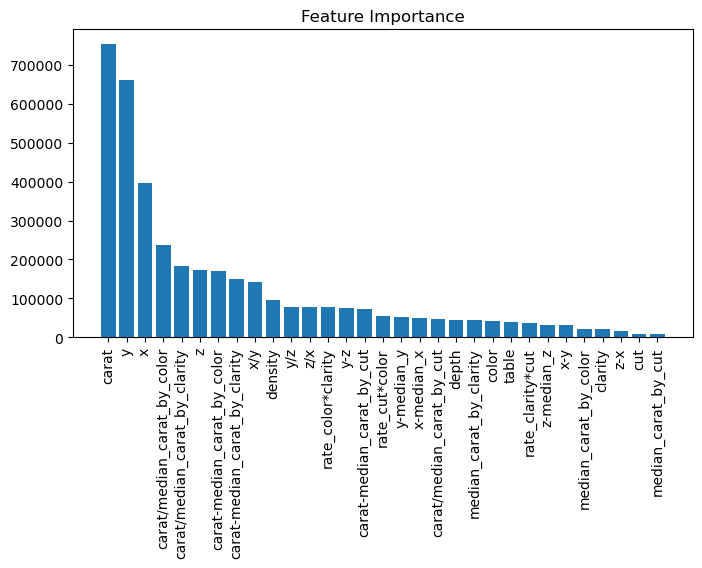

In [17]:
# 特徴量重要度の可視化
importances = model.feature_importance(importance_type='gain') # 特徴量重要度
indices = np.argsort(importances)[::-1] # 特徴量重要度を降順にソート

plt.figure(figsize=(8, 4)) #プロットのサイズ指定
plt.title('Feature Importance') # プロットのタイトルを作成
plt.bar(range(len(indices)), importances[indices]) # 棒グラフを追加
plt.xticks(range(len(indices)), X.columns[indices], rotation=90) # X軸に特徴量の名前を追加
plt.show() # プロットを表示